# Documentation

In [ ]:
#@title Imports & Config

airline = 'WN' #@param ['WN', 'NZ', 'B6', 'LA', 'JQ']
project_id = 'fusionrm-wn-non-prod-358535077' #@param {type:"string"}
cdm_project_id = 'fusionrm-wn-data-prod-34388140' #@param {type:"string"}
cdm_partition = '2021-11-10' #@param {type:"date"}
scenario_ts_challenger = "2021-11-14T17:02:00.000000" #@param {type:"string"}
scenario_ts_champion = "2021-11-14T17:01:00.000000" #@param {type:"string"}
tfrecords_in_bq = "fusionrm-wn-non-prod-358535077.common.wn_4328" #@param {type:"string"}
challenger_id = 4825 #@param {type:"integer"}
is_challenger_dry_run = True #@param {type:"boolean"}
champion_id = 4488 #@param {type:"integer"}
is_champion_dry_run = True #@param {type:"boolean"}
environment = 'staging' #@param ["staging", "integration"] {type:"raw"}
dry_line_challenger = '_dry' if is_challenger_dry_run else '' 
dry_line_champion = '_dry' if is_champion_dry_run else '' 

import os, warnings

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

from datetime import datetime
from google.cloud import bigquery
from google.colab import auth
from IPython.display import clear_output
from sklearn.utils import shuffle

auth.authenticate_user()
client = bigquery.Client(project=project_id)

warnings.filterwarnings("ignore")
clear_output(wait=False)

print('All new libraries have been installed & config has been set up')
 

All new libraries have been installed & config has been set up


(-1.0, 101.0)

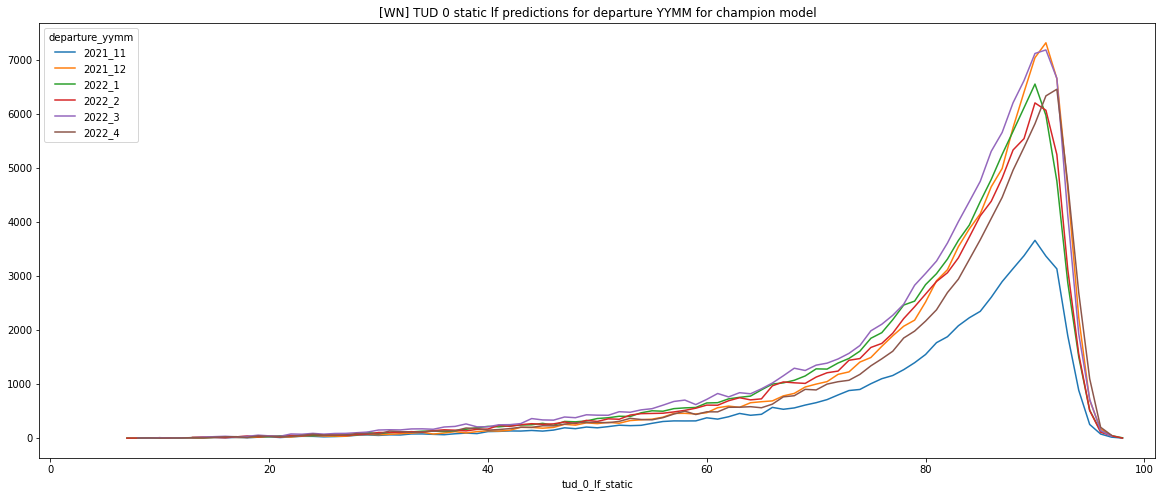

In [ ]:
#@title [Predictions][Line Plot] Final RASK/LF Static/Dynamic ~ Departure YYYYMM
model = 'champion' #@param ['challenger', 'champion'] {type:"string"}
predictions = 'static' #@param ['static', 'dynamic'] {type:"string"}
predicted_measure = 'lf' #@param ['lf', 'rask'] {type:"string"}
tud = 0 #@param {type:"slider", min:0, max:180, step:1}
user_xmin = 0 #@param {type: "integer"}
user_xmax =  100#@param {type: "integer"}

if model == 'challenger':
    scenario_time = scenario_ts_challenger
else:
    scenario_time = scenario_ts_champion

query=f'''WITH
  {predictions}_prediction AS (
  SELECT
    flight_id,
    DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
    {predictions}.tud_days,
    {predictions}.load_factor_regression AS lf_{predictions},
    {predictions}.rask_regression AS rask_{predictions},
    offset_tud
  FROM
    `{project_id}.model_outputs.{environment}_build_model_outputs_dry`,
    UNNEST({predictions}) AS {predictions} WITH OFFSET AS offset_tud
  WHERE
    scenario_timestamp = '{scenario_time}'
    AND tud_days = {tud}),
pre_summary AS (
SELECT
  flight_id,
  dep_date,
  EXTRACT(month from dep_date) AS dep_month,
  EXTRACT(year from dep_date) AS dep_year,
  ROUND(lf_{predictions}*100,0) AS tud_{tud}_lf_{predictions},
  ROUND(rask_{predictions},0) AS tud_{tud}_rask_{predictions},
FROM
  {predictions}_prediction
)

SELECT CONCAT(dep_year, '_',dep_month) AS departure_yymm, 
tud_{tud}_lf_{predictions},
tud_{tud}_rask_{predictions},
COUNT(*) AS flights
FROM pre_summary
GROUP BY 1,2,3
ORDER BY 1 ASC
'''
query_job = client.query(query) 
lf_output_full = query_job.result().to_dataframe()
lf_output_full.groupby([f'tud_{tud}_{predicted_measure}_{predictions}','departure_yymm',]).sum()['flights'].unstack().plot(legend=True, figsize=(20, 8))
plt.title(f'[{airline}] TUD {tud} {predictions} {predicted_measure} predictions for departure YYMM for {model} model')

plt.xlim(user_xmin-1, user_xmax+1)

(-1.0, 101.0)

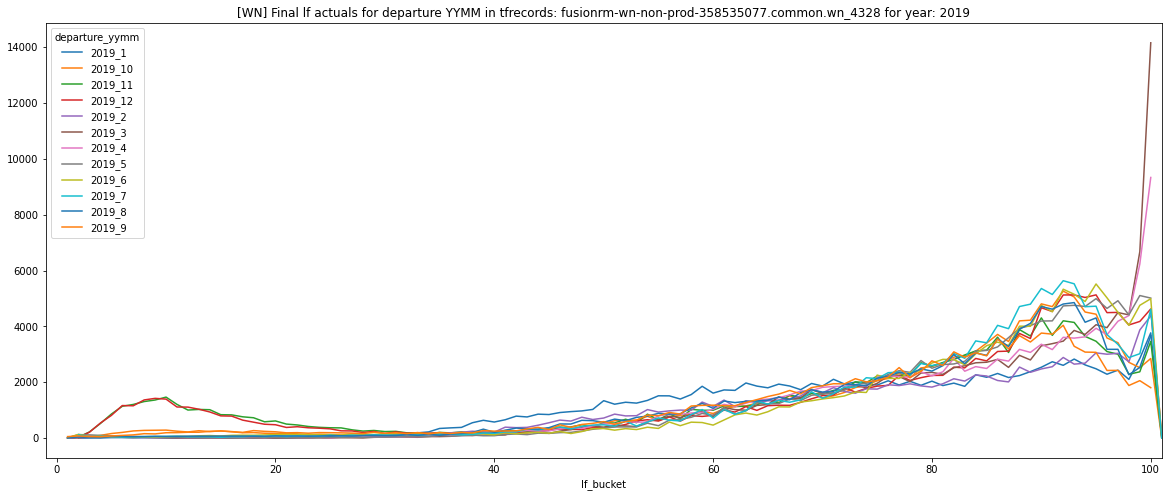

In [ ]:
#@title [Actuals][Line Plot][TfRecords] Final RASK/LF Static/Dynamic ~ Departure YYYYMM
measure = 'lf' #@param ['lf', 'rask'] {type:"string"}
show_year = 2019 #@param {type:"slider", min:2018, max:2021, step:1}
user_xmin = 0 #@param {type: "integer"}
user_xmax = 100 #@param {type: "integer"}

query=f'''WITH
  raw_tfrecords AS (
  SELECT
    itin_id,
    EXTRACT(month
    FROM
      dep_datetime) AS dep_month,
    EXTRACT(year
    FROM
      dep_datetime) AS dep_year,
    fake_tud,
    load_factor_raw
  FROM
    `{tfrecords_in_bq}`,
    UNNEST(ta_lf) AS load_factor_raw
  WITH
  OFFSET
    AS fake_tud ),
  ranked_tfrecords AS (
  SELECT
    dep_year,
    dep_month,
    itin_id,
    lf_final,
    ROW_NUMBER() OVER(PARTITION BY itin_id ORDER BY fake_tud DESC) AS rn
  FROM
    raw_tfrecords,
    UNNEST(load_factor_raw.
    VALUES
      ) AS lf_final ),
  lf_presummary AS (
  SELECT
    dep_year,
    dep_month,
    itin_id,
    ROUND(AVG(lf_final)*100,0) AS load_factor
  FROM
    ranked_tfrecords
  WHERE
    rn=2
  GROUP BY
    dep_year,
    dep_month,
    itin_id ),
  lf_final AS (
  SELECT
    dep_year,
    dep_month,
    ROUND(load_factor,2) AS lf_bucket,
    COUNT(*) AS flights
  FROM
    lf_presummary
  GROUP BY
    1,
    2,
    3 ),
  raw_rev_tfrecords AS (
  SELECT
    itin_id,
    EXTRACT(month
    FROM
      dep_datetime) AS dep_month,
    EXTRACT(year
    FROM
      dep_datetime) AS dep_year,
    fake_tud,
    rev_new_raw,
    ask_raw
  FROM
    `{tfrecords_in_bq}`,
    UNNEST(total_rev_new) AS rev_new_raw
  WITH
  OFFSET
    AS fake_tud,
    UNNEST(total_ask) AS ask_raw
  WITH
  OFFSET
    AS fake_tud_ask
  WHERE
    fake_tud = fake_tud_ask ),
  rask_presummary AS (
  SELECT
    dep_year,
    dep_month,
    itin_id,
    SAFE_DIVIDE(SUM(rev_new_raw),AVG(ask_raw))*100 AS total_rask,
  FROM
    raw_rev_tfrecords
  GROUP BY
    1,
    2,
    3 ),
    rask_buckets AS (
SELECT
    dep_year,
    dep_month,
    itin_id,
    ROUND(total_rask,0) AS rask_bucket
  FROM
    rask_presummary
    ),
rask_final AS (
SELECT dep_year,
dep_month,
rask_bucket,
COUNT(*) AS flights
FROM rask_buckets
GROUP BY 1,2,3
)

SELECT *,
CONCAT(dep_year,'_',dep_month) AS departure_yymm
FROM {measure}_final
WHERE dep_year = {show_year}

'''
query_job = client.query(query) 
summary_full = query_job.result().to_dataframe()

summary_full.groupby([f'{measure}_bucket','departure_yymm',]).sum()['flights'].unstack().plot(legend=True, figsize=(20, 8))
plt.title(f'[{airline}] Final {measure} actuals for departure YYMM in tfrecords: {tfrecords_in_bq} for year: {show_year}')

plt.xlim(user_xmin-1, user_xmax+1)


WITH Input AS (
SELECT flight_id,
EXTRACT(month FROM DATE(SPLIT(flight_id, '_')[OFFSET(2)])) AS dep_month,
EXTRACT(year FROM DATE(SPLIT(flight_id, '_')[OFFSET(2)])) AS dep_year,
seats_sold_cabin/total_sellable_seats_cabin AS load_factor 
FROM `fusionrm-wn-data-prod-34388140.cdm_views.flight_inventories` 
WHERE tud_days=0
AND total_sellable_seats_cabin <> 0
),
lf_buckets AS (
SELECT dep_year,
dep_month,
CONCAT(dep_year,'_', dep_month) AS departure_yymm,
ROUND(load_factor*100,0) AS lf_bucket
FROM Input
WHERE load_factor IS NOT NULL
),
final_summary AS (
SELECT departure_yymm,
dep_year,
lf_bucket,
COUNT(*) AS flights
FROM lf_buckets
GROUP BY departure_yymm, dep_year, lf_bucket
)

SELECT * FROM final_summary
WHERE dep_year = 2019



Text(0.5, 1.0, '[WN] final LF actuals for departure YYMM in CDM: fusionrm-wn-data-prod-34388140 for year: 2019')

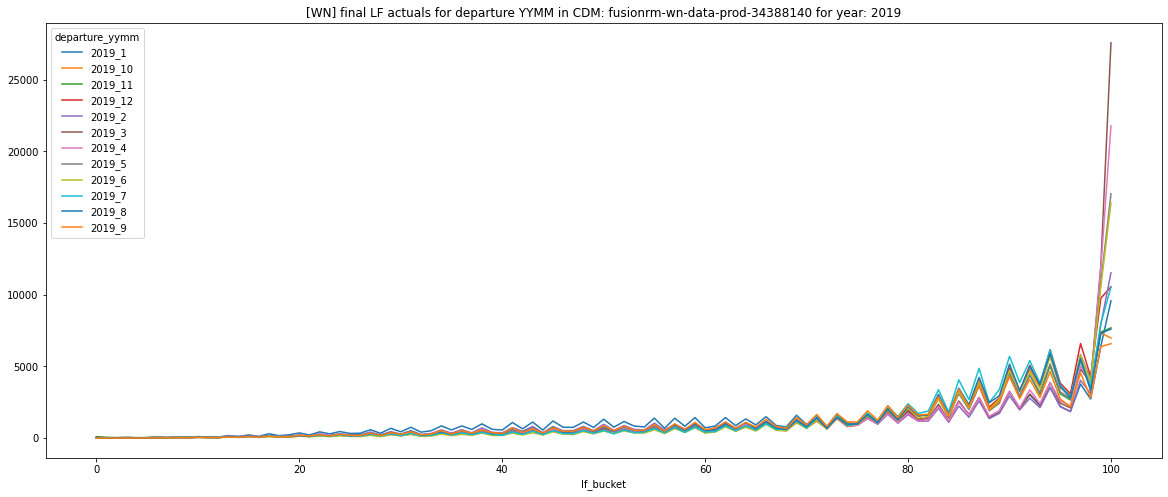

In [ ]:
#@title [Revisit][Actuals][Line Plot][CDM] Final LF Summary

show_year = 2019 #@param {type:"slider", min:2018, max:2021, step:1}
query =f'''
WITH Input AS (
SELECT flight_id,
EXTRACT(month FROM DATE(SPLIT(flight_id, '_')[OFFSET(2)])) AS dep_month,
EXTRACT(year FROM DATE(SPLIT(flight_id, '_')[OFFSET(2)])) AS dep_year,
seats_sold_cabin/total_sellable_seats_cabin AS load_factor 
FROM `{cdm_project_id}.cdm_views.flight_inventories` 
WHERE tud_days=0
AND total_sellable_seats_cabin <> 0
),
lf_buckets AS (
SELECT dep_year,
dep_month,
CONCAT(dep_year,'_', dep_month) AS departure_yymm,
ROUND(load_factor*100,0) AS lf_bucket
FROM Input
WHERE load_factor IS NOT NULL
),
final_summary AS (
SELECT departure_yymm,
dep_year,
lf_bucket,
COUNT(*) AS flights
FROM lf_buckets
GROUP BY departure_yymm, dep_year, lf_bucket
)

SELECT * FROM final_summary
WHERE dep_year = {show_year}
'''

query_job = client.query(query) 
summary_full = query_job.result().to_dataframe()

summary_full.groupby([f'lf_bucket','departure_yymm',]).sum()['flights'].unstack().plot(legend=True, figsize=(20, 8))
plt.title(f'[{airline}] final LF actuals for departure YYMM in CDM: {cdm_project_id} for year: {show_year}')


In [ ]:
#@title [Predictions][Scatter Plot] RASK ~ LF Static/Dynamic ~ Market
model = 'champion' #@param ['challenger', 'champion'] {type:"string"}
predictions = 'static' #@param ['static', 'dynamic'] {type:"string"}
rask_max = 25 #@param {type: "integer"}
dep_month = 4 #@param {type:"slider", min:1, max:12, step:1}
dep_year = 2022 #@param {type:"slider", min:2021, max:2022, step:1}

if model == 'challenger':
    scenario_time = scenario_ts_challenger
else:
    scenario_time = scenario_ts_champion

query=f'''
WITH
  {predictions}_prediction AS (
  SELECT
    flight_id,
    SUBSTR(flight_id,1,3) AS origin,
    SUBSTR(flight_id,4,3) AS destination,
    DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
    {predictions}.tud_days,
    {predictions}.load_factor_regression AS lf_{predictions},
    {predictions}.rask_regression AS rask_{predictions},
    offset_tud
  FROM
    `{project_id}.model_outputs.{environment}_build_model_outputs{dry_line_challenger}`,
    UNNEST({predictions}) AS {predictions} WITH OFFSET AS offset_tud
  WHERE
    scenario_timestamp = '{scenario_time}'
    AND tud_days = 0),
pre_summary AS (
SELECT
  flight_id,
  origin,
  destination,
  dep_date,
  ROUND(lf_{predictions}*100,0) AS final_lf_{predictions},
  ROUND(rask_{predictions},2) AS final_rask_{predictions},
FROM
  {predictions}_prediction
),
pre_summary_with_dep_month_and_market AS (
SELECT 
 *,
 EXTRACT(month FROM dep_date) AS dep_month,
 EXTRACT(year FROM dep_date) AS dep_year,
 CASE WHEN origin > destination THEN CONCAT(destination, origin)
 ELSE CONCAT(origin,destination)
 END AS market, 
FROM 
 pre_summary
),
summary AS (
SELECT 
market,
AVG(final_lf_{predictions}) AS avg_lf_{predictions},
AVG(final_rask_{predictions}) AS avg_rask_{predictions},
SUBSTR(market,1,3) AS origin, 
FROM pre_summary_with_dep_month_and_market
WHERE dep_month = {dep_month}
AND dep_year = {dep_year}
GROUP BY market
),
distinct_origins AS (
SELECT DISTINCT origin AS origin
FROM summary
),
origin_symbols AS (
SELECT origin, 
ROW_NUMBER() OVER (ORDER BY RAND()*RAND()/(RAND()-RAND())) AS symbol
FROM distinct_origins
)

SELECT summary.*, symbol.symbol
FROM summary
LEFT JOIN origin_symbols symbol
USING (origin)
ORDER BY 4 ASC
'''

query_job = client.query(query) 
avg_and_stddev_lac = query_job.result().to_dataframe()

fig = px.scatter(avg_and_stddev_lac, 
                 x=f'avg_lf_{predictions}', 
                 y=f'avg_rask_{predictions}',
                 hover_name='market',
                 color = 'origin',
                 symbol = 'symbol',
                 width = 1000,
                 height = 750,
                 title=f"[{airline}] average {predictions} LF and RASK final departure predictions \n for {model} model & dep_year: {dep_year} & dep_month: {dep_month}")

fig.update_layout(showlegend=False)
fig.show()


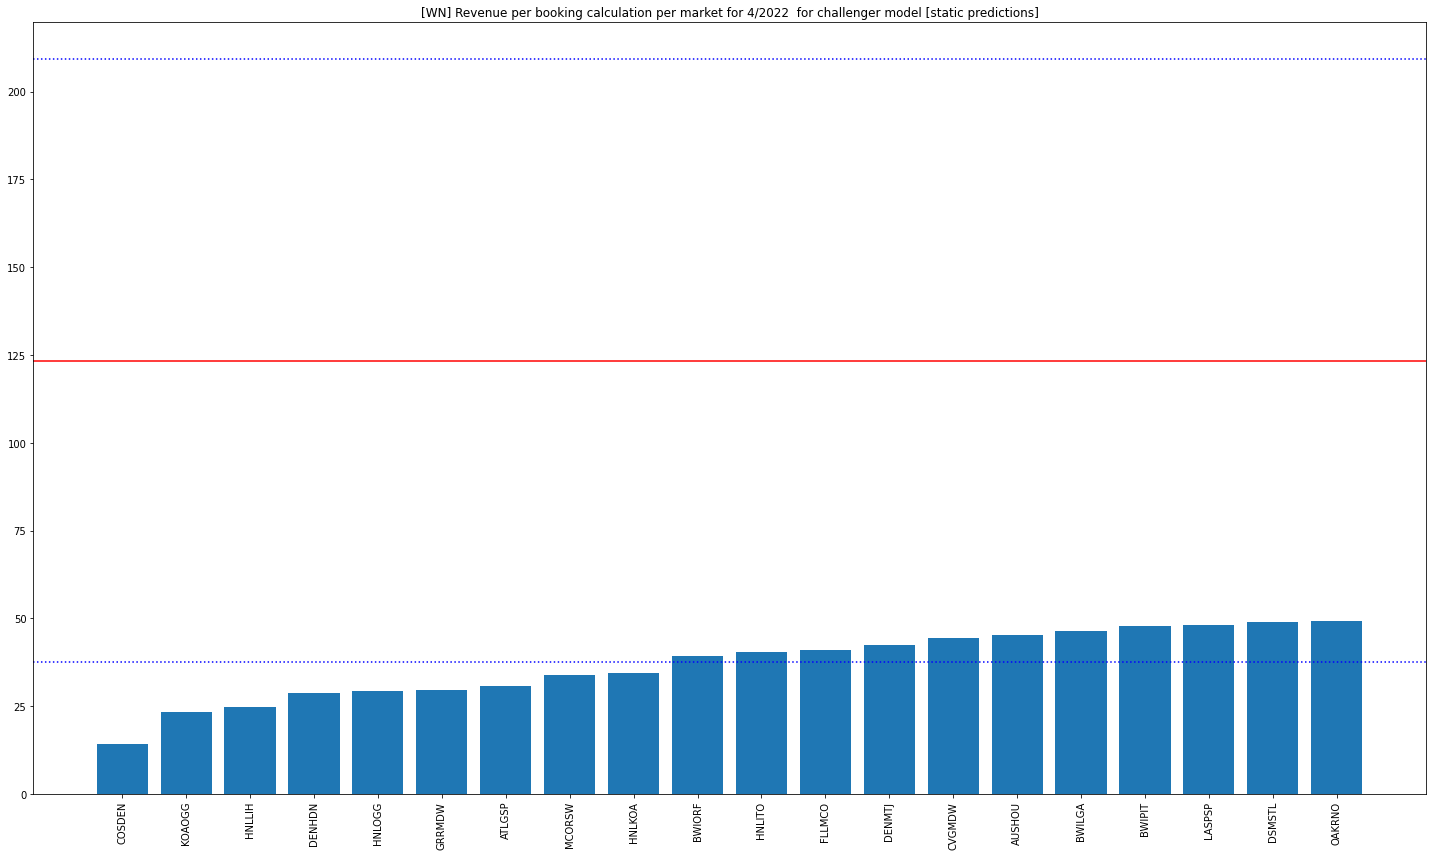

In [ ]:
#@title [Predictions][Bar Plot] Static/Dynamic Revenue per Booking ~ market

model = 'challenger' #@param ['challenger', 'champion'] {type:"string"}
predictions = 'static' #@param ['static', 'dynamic'] {type:"string"}
chart_type = 'Bottom N' #@param ['All markets', 'Top N', 'Bottom N'] {type:"string"}
n_markets = 20 #@param {type:"slider", min:10, max:50, step:10}
dep_month = 1 #@param {type:"slider", min:1, max:12, step:1}
dep_year = 2022 #@param {type:"slider", min:2021, max:2023, step:1}
stddev_mult = 2 #@param {type:"slider", min:1, max:3, step:1}

if model == 'challenger':
    scenario_time = scenario_ts_challenger
else:
    scenario_time = scenario_ts_champion


stddev_mult = int(stddev_mult)

query=f'''
WITH
  {predictions}_prediction AS (
  SELECT
    flight_id,
    SUBSTR(flight_id,1,3) AS origin,
    SUBSTR(flight_id,4,3) AS destination,
    DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
    {predictions}.tud_days,
    {predictions}.load_factor_regression AS lf_{predictions},
    {predictions}.rask_regression AS rask_{predictions},
    offset_tud
  FROM
    `{project_id}.model_outputs.{environment}_build_model_outputs{dry_line_challenger}`,
    UNNEST({predictions}) AS {predictions} WITH OFFSET AS offset_tud
  WHERE
    scenario_timestamp = '{scenario_time}'
    AND tud_days = 0),
pre_summary AS (
SELECT
  flight_id,
  origin,
  destination,
  DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
  ROUND(lf_{predictions}*100,0) AS final_lf_{predictions},
  ROUND(rask_{predictions},2) AS final_rask_{predictions},
FROM
  {predictions}_prediction
),
pre_summary_with_dep_month_and_market AS (
SELECT 
 *,
 EXTRACT(month FROM dep_date) AS dep_month,
 EXTRACT(year FROM dep_date) AS dep_year,
 CASE WHEN origin > destination THEN 
 CONCAT(destination, origin) 
 ELSE CONCAT(origin,destination)
 END AS market, 
FROM 
 pre_summary
),
summary AS (
SELECT 
market,
dep_month,
dep_year,
AVG(final_lf_{predictions}) AS avg_lf_{predictions},
AVG(final_rask_{predictions}) AS avg_rask_{predictions},
FROM pre_summary_with_dep_month_and_market
GROUP BY market, dep_month, dep_year
),
preaggregate AS (
SELECT
    origin,
    destination,
    dep_datetime,
    CASE WHEN origin > destination THEN CONCAT(destination,origin) ELSE CONCAT(origin,destination) END AS market,
    EXTRACT(month FROM dep_datetime) AS dep_month,
    EXTRACT(year FROM dep_datetime) AS dep_year,    
    distance_km,
    lid,
    distance_km * lid AS ask
  FROM
    `{cdm_project_id}.cdm_views.legs` legs
  LEFT JOIN 
    `{cdm_project_id}.cdm_views.flight_inventories` invs
  ON legs.leg_id = invs.leg_id AND 
  DATE(legs.processed_at) = DATE(invs.processed_at)
  WHERE 
    DATE(legs.processed_at) = '{cdm_partition}'
    AND DATE(invs.processed_at) = '{cdm_partition}'
),
aggregate AS (
SELECT market, dep_year, dep_month, SUM(lid) AS total_seats, SUM(ask) AS total_ask
FROM preaggregate 
GROUP BY market, dep_year, dep_month
ORDER BY market, dep_year, dep_month
),
merge_summary_with_aggregates AS
(
SELECT summary.*, aggregate.total_seats, aggregate.total_ask 
FROM summary
LEFT JOIN aggregate 
USING (market, dep_month, dep_year)
ORDER BY 4 ASC
),
calculate_bookings_and_revenue AS
(
SELECT market, dep_month, dep_year, ROUND(total_seats * avg_lf_{predictions}/100,0) AS bookings,
avg_rask_{predictions} * total_ask / 100 AS usd_revenue
FROM merge_summary_with_aggregates
)
SELECT market, dep_month, dep_year,
usd_revenue/bookings AS revenue_per_booking
FROM calculate_bookings_and_revenue
WHERE usd_revenue > 0
AND dep_month = {dep_month}
AND dep_year = {dep_year}
ORDER BY 4 ASC
'''

query_job = client.query(query) 
actual_summary = query_job.result().to_dataframe()


average = actual_summary['revenue_per_booking'].values.mean()
std = actual_summary['revenue_per_booking'].values.std()


plt.figure(figsize=(20,12))
plt.title(f'[{airline}] Revenue per booking calculation per market for 4/2022  for {model} model [{predictions} predictions]')
if chart_type == 'All markets':
    plt.bar(actual_summary['market'], actual_summary['revenue_per_booking']) 

elif chart_type == 'Top N':   
    plt.bar(actual_summary['market'][-n_markets:], actual_summary['revenue_per_booking'][-n_markets:]) 

elif chart_type == 'Bottom N':   
    plt.bar(actual_summary['market'][:n_markets], actual_summary['revenue_per_booking'][:n_markets]) 


plt.axhline(y=average+stddev_mult*std, color='b', linestyle=':')
plt.axhline(y=average, color='r', linestyle='-')
plt.axhline(y=average-stddev_mult*std, color='b', linestyle=':')
plt.xticks(rotation=90)
plt.tight_layout()



In [ ]:
#@title [Predictions][Table] Table summary

model = 'challenger' #@param ['challenger', 'champion'] {type:"string"}
predictions = 'static' #@param ['static', 'dynamic'] {type:"string"}
dep_month = 4 #@param {type:"slider", min:1, max:12, step:1}
dep_year = 2022 #@param {type:"slider", min:2021, max:2023, step:1}
order = 'ASC' #@param ['ASC', 'DESC']
limit = 20 #@param {type:"slider", min:10, max:50, step:10}

if model == 'challenger':
    scenario_time = scenario_ts_challenger
else:
    scenario_time = scenario_ts_champion

query=f'''
WITH
  {predictions}_prediction AS (
  SELECT
    flight_id,
    SUBSTR(flight_id,1,3) AS origin,
    SUBSTR(flight_id,4,3) AS destination,
    DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
    {predictions}.tud_days,
    {predictions}.load_factor_regression AS lf_{predictions},
    {predictions}.rask_regression AS rask_{predictions},
    offset_tud
  FROM
    `{project_id}.model_outputs.{environment}_build_model_outputs{dry_line_challenger}`,
    UNNEST({predictions}) AS {predictions} WITH OFFSET AS offset_tud
  WHERE
    scenario_timestamp = '{scenario_time}'
    AND tud_days = 0),
pre_summary AS (
SELECT
  flight_id,
  origin,
  destination,
  DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
  ROUND(lf_{predictions}*100,0) AS final_lf_{predictions},
  ROUND(rask_{predictions},2) AS final_rask_{predictions},
FROM
  {predictions}_prediction
),
pre_summary_with_dep_month_and_market AS (
SELECT 
 *,
 EXTRACT(month FROM dep_date) AS dep_month,
 EXTRACT(year FROM dep_date) AS dep_year,
 CASE WHEN origin > destination THEN CONCAT(destination, origin)
 END AS market, 
FROM 
 pre_summary
),
summary AS (
SELECT 
market,
dep_month,
dep_year,
AVG(final_lf_{predictions}) AS avg_lf_{predictions},
AVG(final_rask_{predictions}) AS avg_rask_{predictions},
FROM pre_summary_with_dep_month_and_market
GROUP BY market, dep_month, dep_year
),
preaggregate AS (
SELECT
    origin,
    destination,
    dep_datetime,
    CASE WHEN origin > destination THEN CONCAT(destination,origin) ELSE CONCAT(origin,destination) END AS market,
    EXTRACT(month FROM dep_datetime) AS dep_month,
    EXTRACT(year FROM dep_datetime) AS dep_year,    
    distance_km,
    lid,
    distance_km * lid AS ask
  FROM
    `{cdm_project_id}.cdm_views.legs` legs
  LEFT JOIN 
    `{cdm_project_id}.cdm_views.flight_inventories` invs
  ON legs.leg_id = invs.leg_id AND 
  DATE(legs.processed_at) = DATE(invs.processed_at)
  WHERE 
    DATE(legs.processed_at) = '{cdm_partition}'
    AND DATE(invs.processed_at) = '{cdm_partition}'
),
aggregate AS (
SELECT market, dep_year, dep_month, SUM(lid) AS total_seats, SUM(ask) AS total_ask
FROM preaggregate 
GROUP BY market, dep_year, dep_month
ORDER BY market, dep_year, dep_month
),
merge_summary_with_aggregates AS
(
SELECT summary.*, aggregate.total_seats, aggregate.total_ask 
FROM summary
LEFT JOIN aggregate 
USING (market, dep_month, dep_year)
ORDER BY 4 ASC
),
calculate_bookings_and_revenue AS
(
SELECT market, dep_month, dep_year, 
ROUND(total_seats * avg_lf_{predictions}/100,0) AS bookings,
total_ask, total_seats,
avg_rask_{predictions} * total_ask / 100 AS usd_revenue
FROM merge_summary_with_aggregates
)
SELECT market, ROUND(usd_revenue,0) AS usd_revenue, bookings, 
ROUND(total_ask,0) AS total_ask, 
total_seats, 
ROUND(usd_revenue/bookings,0) AS revenue_per_booking
FROM calculate_bookings_and_revenue
WHERE usd_revenue > 0
AND dep_month = {dep_month}
AND dep_year = {dep_year}
ORDER BY 6 {order}
LIMIT {limit}
'''

query_job = client.query(query) 
actual_summary = query_job.result().to_dataframe()
print(f'[{airline}] Summary for {predictions} predictions {dep_year}/{dep_month}')
actual_summary

[WN] Summary for static predictions 2022/4


,market,usd_revenue,bookings,total_ask,total_seats,revenue_per_booking
0,COSDEN,172088.0,14428.0,2780090,23664,12.0
1,KOAOGG,79607.0,3686.0,1135550,8400,22.0
2,DENHDN,367363.0,15882.0,4672674,20592,23.0
3,HNLLIH,317666.0,13706.0,5515530,33600,23.0
4,HNLOGG,611766.0,23317.0,8111074,50400,26.0
5,MCORSW,195070.0,6654.0,1606173,7504,29.0
6,ATLGSP,299936.0,9558.0,3569336,14496,31.0
7,HNLKOA,442813.0,13944.0,8814033,33600,32.0
8,FLLMCO,294563.0,9001.0,3766898,13224,33.0
9,HNLITO,281134.0,8036.0,11679946,33600,35.0


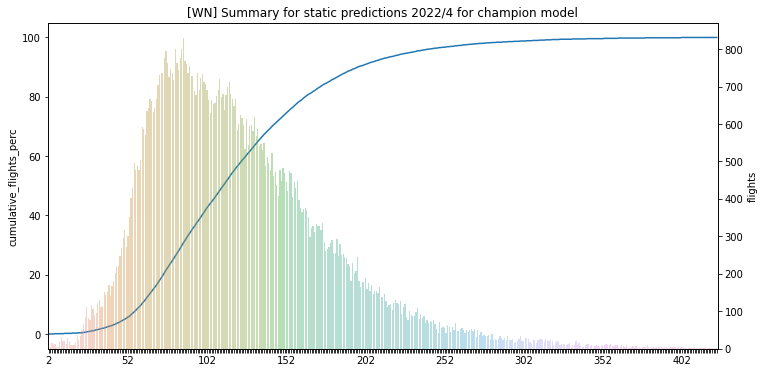

In [ ]:
#@title [Predictions][Distribution Plot] Revenue per booking ~ percentage of flights

model = 'champion' #@param ['challenger', 'champion'] {type:"string"}
predictions = 'static' #@param ['static', 'dynamic'] {type:"string"}
dep_month = 4 #@param {type:"slider", min:1, max:12, step:1}
dep_year = 2022 #@param {type:"slider", min:2021, max:2023, step:1}

if model == 'challenger':
    scenario_time = scenario_ts_challenger
else:
    scenario_time = scenario_ts_champion

query=f'''
WITH
  {predictions}_prediction AS (
  SELECT
    flight_id,
    SUBSTR(flight_id,1,3) AS origin,
    SUBSTR(flight_id,4,3) AS destination,
    DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
    {predictions}.tud_days,
    {predictions}.load_factor_regression AS lf_{predictions},
    {predictions}.rask_regression AS rask_{predictions},
    offset_tud
  FROM
    `{project_id}.model_outputs.{environment}_build_model_outputs{dry_line_challenger}`,
    UNNEST({predictions}) AS {predictions} WITH OFFSET AS offset_tud
  WHERE
    scenario_timestamp = '{scenario_time}'
    AND tud_days = 0),
pre_summary AS (
SELECT
  flight_id,
  origin,
  destination,
  DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
  ROUND(lf_{predictions}*100,0) AS final_lf_{predictions},
  ROUND(rask_{predictions},2) AS final_rask_{predictions},
FROM
  {predictions}_prediction
),
pre_summary_with_dep_month AS (
SELECT 
 *,
 SUBSTR(flight_id,1,LENGTH(flight_id)-2) AS leg_id,
 EXTRACT(month FROM dep_date) AS dep_month,
 EXTRACT(year FROM dep_date) AS dep_year,
FROM 
 pre_summary
),
summary AS (
SELECT 
leg_id,
dep_month,
dep_year,
AVG(final_lf_{predictions}) AS avg_lf_{predictions},
AVG(final_rask_{predictions}) AS avg_rask_{predictions},
FROM pre_summary_with_dep_month
GROUP BY leg_id, dep_month, dep_year
),
preaggregate AS (
SELECT
    legs.leg_id,
    EXTRACT(month FROM dep_datetime) AS dep_month,
    EXTRACT(year FROM dep_datetime) AS dep_year,    
    distance_km,
    lid,
    distance_km * lid AS ask
  FROM
    `{cdm_project_id}.cdm_views.legs` legs
  LEFT JOIN 
    `{cdm_project_id}.cdm_views.flight_inventories` invs
  ON legs.leg_id = invs.leg_id AND 
  DATE(legs.processed_at) = DATE(invs.processed_at)
  WHERE 
    DATE(legs.processed_at) = '{cdm_partition}'
    AND DATE(invs.processed_at) = '{cdm_partition}'
),
aggregate AS (
SELECT leg_id, dep_year, dep_month, SUM(lid) AS total_seats, SUM(ask) AS total_ask
FROM preaggregate 
GROUP BY leg_id, dep_year, dep_month
ORDER BY leg_id, dep_year, dep_month
),
merge_summary_with_aggregates AS
(
SELECT summary.*, aggregate.total_seats, aggregate.total_ask 
FROM summary
LEFT JOIN aggregate 
USING (leg_id, dep_month, dep_year)
ORDER BY 4 ASC
),
calculate_bookings_and_revenue AS
(
SELECT leg_id, dep_month, dep_year, ROUND(total_seats * avg_lf_{predictions}/100,0) AS bookings,
total_ask, total_seats,
avg_rask_{predictions} * total_ask / 100 AS usd_revenue
FROM merge_summary_with_aggregates
),
pre_groupby_stage_1 AS (
SELECT ROUND(usd_revenue/bookings,0) AS revenue_per_booking
FROM calculate_bookings_and_revenue
WHERE usd_revenue > 0
AND dep_month = {dep_month}
AND dep_year = {dep_year}
),
pre_groupby_stage_2 AS (
SELECT CAST(revenue_per_booking AS INT64) AS revenue_per_booking, 
COUNT(*) AS flights
FROM pre_groupby_stage_1
GROUP BY revenue_per_booking),
flights AS (
SELECT COUNT(*) AS total 
FROM pre_groupby_stage_1
)


SELECT revenue_per_booking AS revenue_per_booking,
flights,
ROUND(SUM(flights) OVER(ORDER BY revenue_per_booking) / (SELECT total FROM flights) * 100,1) AS cumulative_flights_perc
FROM pre_groupby_stage_2
ORDER BY revenue_per_booking

'''

query_job = client.query(query) 
actual_summary = query_job.result().to_dataframe()

ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = actual_summary['cumulative_flights_perc'], 
             sort = False, 
             ax=ax1)

ax2 = ax1.twinx()

sns.barplot(data = actual_summary, 
            x='revenue_per_booking', 
            y='flights', 
            alpha=0.4, 
            ax=ax2)

plt.title(f'[{airline}] Summary for {predictions} predictions {dep_year}/{dep_month} for {model} model')

for ind, label in enumerate(ax1.get_xticklabels()):
    if ind % 50 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)


Text(0.5, 1.0, '[WN] RASK ~ LF Bucket static summary with % distribution for model champion for dep_month: 4')

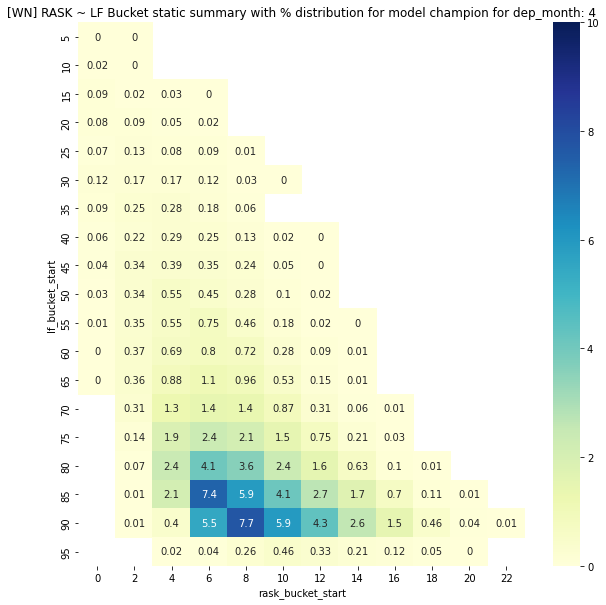

In [ ]:
#@title [Predictions][Heat Map] Final RASK ~ LF Static/Dynamic ~ % of flights

model = 'champion' #@param ['challenger', 'champion'] {type:"string"}
predictions = 'static' #@param ['static', 'dynamic'] {type:"string"}
rask_max = 50 #@param {type: "integer"}
lf_bucket_size =  5#@param {type: "integer"}
rask_bucket_size =  2#@param {type: "integer"}
dep_month = 4 #@param {type: "integer"}
annotation = True #@param {type: "boolean"}
colorscale_max = 10 #@param {type: "integer"}

if model == 'challenger':
    scenario_time = scenario_ts_challenger
else:
    scenario_time = scenario_ts_champion
query = f'''
WITH
  {predictions}_prediction AS (
  SELECT
    flight_id,
    SUBSTR(flight_id,1,3) AS origin,
    SUBSTR(flight_id,4,3) AS destination,
    DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
    {predictions}.tud_days,
    {predictions}.load_factor_regression AS lf_{predictions},
    {predictions}.rask_regression AS rask_{predictions},
    offset_tud
  FROM
    `{project_id}.model_outputs.{environment}_build_model_outputs{dry_line_challenger}`,
    UNNEST({predictions}) AS {predictions} WITH OFFSET AS offset_tud
  WHERE
    scenario_timestamp = '{scenario_time}'
    AND tud_days = 0),
pre_summary AS (
SELECT
  flight_id,
  origin,
  destination,
  DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
  ROUND(lf_{predictions}*100,0) AS final_lf_{predictions},
  ROUND(rask_{predictions},2) AS final_rask_{predictions},
FROM
  {predictions}_prediction
),
pre_summary_with_dep_month_and_market AS (
SELECT 
 *,
 EXTRACT(month FROM dep_date) AS dep_month,
 CASE WHEN origin > destination THEN CONCAT(destination, origin)
 END AS market, 
FROM 
 pre_summary
),
summary AS (
SELECT 
flight_id,
AVG(final_lf_{predictions}) AS avg_lf_{predictions},
AVG(final_rask_{predictions}) AS avg_rask_{predictions}
FROM pre_summary_with_dep_month_and_market
WHERE dep_month = {dep_month}
GROUP BY flight_id
),
assign_buckets AS (
SELECT flight_id,
avg_lf_{predictions},
avg_rask_{predictions},
ROUND(FLOOR(avg_lf_{predictions} / {lf_bucket_size}),0) AS lf_bucket,
ROUND(FLOOR(avg_rask_{predictions}/ {rask_bucket_size}),0) AS rask_bucket,
FROM summary
),
add_labels AS (
SELECT
flight_id,
avg_lf_{predictions},
avg_rask_{predictions},
lf_bucket,
rask_bucket,
CONCAT(CAST(ROUND(lf_bucket * {lf_bucket_size},0) AS STRING), '-',
CAST(ROUND((lf_bucket + 1) * {lf_bucket_size}) AS STRING)) AS lf_label,
CONCAT(CAST(ROUND(rask_bucket * {rask_bucket_size},1) AS STRING), '-',
CAST(ROUND((rask_bucket + 1) * {rask_bucket_size},1) AS STRING)) AS rask_label,
FROM assign_buckets
),
final_summary AS (
SELECT lf_label,lf_bucket, rask_label, rask_bucket, COUNT(*) AS no_of_flights
FROM add_labels
GROUP BY lf_label,lf_bucket, rask_label, rask_bucket
ORDER BY lf_bucket DESC, rask_bucket DESC
),
total_flights AS
(SELECT COUNT(*) AS total
FROM add_labels)

SELECT CAST(lf_bucket * {lf_bucket_size} AS int) AS lf_bucket_start, 
CAST(rask_bucket * {rask_bucket_size} AS int) AS rask_bucket_start,
ROUND(no_of_flights/(SELECT total FROM total_flights) * 100,2) AS total_flights_perc 
FROM final_summary
WHERE rask_bucket < {rask_max} / {rask_bucket_size}
'''

query_job = client.query(query) 
summary = query_job.result().to_dataframe()
summary_pivot = summary.pivot("lf_bucket_start", "rask_bucket_start", "total_flights_perc")
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(summary_pivot, cmap="YlGnBu", vmin=0, vmax=colorscale_max, annot=annotation)
plt.title(f'[{airline}] RASK ~ LF Bucket {predictions} summary with % distribution for model {model} for dep_month: {dep_month}')


In [ ]:
#@title [Predictions][Animated Scatter Plot] Final RASK~LF Static/Dynamic ~ market ~ departures
model = 'champion' #@param ['challenger', 'champion'] {type:"string"}
predictions = 'dynamic' #@param ['static', 'dynamic'] {type:"string"}
mode = 'Some markets' #@param ['All markets', 'Some markets'] {type:"string"}
markets = 'MCORSW, LASONT, LASSAN, AUSLBB, LASPSP'#@param {type:"string"}

markets = [f'{market}'.lstrip().rstrip() for market in markets.split(',')]
markets = """','""".join(markets)
markets_cleaned = markets.replace(' ', '').replace("'","")
return_markets = [market[3:]+market[:3] for market in markets_cleaned.split(',')]
return_markets = """','""".join(return_markets)

if mode == 'All markets':
    market_line = ''
else:
    market_line = f'''AND (SUBSTR(flight_id,1,6) IN ('{markets}') OR SUBSTR(flight_id,1,6) IN ('{return_markets}') )'''

if model == 'challenger':
    scenario_time = scenario_ts_challenger
else:
    scenario_time = scenario_ts_champion

query = f''' WITH
  {predictions}_prediction AS (
  SELECT
    flight_id,
    SUBSTR(flight_id,1,3) AS origin,
    SUBSTR(flight_id,4,3) AS destination,
    DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
    {predictions}.tud_days,
    {predictions}.load_factor_regression AS lf_{predictions},
    {predictions}.rask_regression AS rask_{predictions},
    offset_tud
  FROM
    `{project_id}.model_outputs.{environment}_build_model_outputs_dry`,
    UNNEST({predictions}) AS {predictions} WITH OFFSET AS offset_tud
  WHERE
    scenario_timestamp = '{scenario_time}'
    AND tud_days = 0
    {market_line}),
summary AS (
SELECT
  flight_id,
  SUBSTR(flight_id,1,LENGTH(flight_id)-2) AS leg_id,
  SUBSTR(flight_id,1,3) AS origin,
  SUBSTR(flight_id,4,3) AS destination,
  DATE(SPLIT(flight_id, '_')[OFFSET(2)]) AS dep_date,
  ROUND(AVG(lf_{predictions})*100,0) AS predicted_{predictions}_lf,
  ROUND(AVG(rask_{predictions}),0) AS predicted_{predictions}_rask
FROM
  {predictions}_prediction
GROUP BY flight_id, dep_date
),
add_market AS
(
SELECT leg_id, 
dep_date, 
CASE WHEN destination > origin THEN CONCAT(origin,destination) 
ELSE CONCAT(destination,origin) END AS market,
DENSE_RANK() OVER(ORDER BY dep_date ASC) AS day_index,
predicted_{predictions}_rask,
predicted_{predictions}_lf,
FROM summary
ORDER BY dep_date
),
market_flights_summary AS (
SELECT market,
dep_date, 
COUNT(*) AS flights,
FROM add_market
GROUP BY market, dep_date    
)

SELECT market,
CAST(dep_date AS STRING) AS dep_date, 
MIN(day_index) AS day_index,
AVG(predicted_{predictions}_rask) AS predicted_{predictions}_rask, 
AVG(predicted_{predictions}_lf) AS predicted_{predictions}_lf,
SUM(flights) AS flights
FROM add_market
LEFT JOIN market_flights_summary 
USING (dep_date, market)
GROUP BY 1,2
ORDER BY dep_date ASC, market ASC 
'''

query_job = client.query(query) 
summary = query_job.result().to_dataframe()

summary.head()

fig = px.scatter(summary, x=f"predicted_{predictions}_rask", 
                y=f"predicted_{predictions}_lf", 
                animation_frame="dep_date", 
                hover_name="market", 
                color="flights",
                title=f"[{airline}] Predictions [{predictions}] for {model} model", 
                log_x=False)

fig.show()

In [ ]:
summary.head()

,market,dep_date,day_index,predicted_dynamic_rask,predicted_dynamic_lf,flights
0,AUSLBB,2021-11-14,1,32.0,100.0,4
1,LASONT,2021-11-14,1,37.4,96.6,25
2,LASPSP,2021-11-14,1,32.0,87.5,4
3,LASSAN,2021-11-14,1,37.4,99.1,100
4,MCORSW,2021-11-14,1,39.0,87.0,4
